<a href="https://colab.research.google.com/github/abbyambita/Diagnosing-COVID-from-CT-Scan-Images/blob/main/visualize_attention_map.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [2]:
%cd "/content/gdrive/My Drive/CS 284 Mini-Project/Code/ViT-pytorch"

/content/gdrive/.shortcut-targets-by-id/1eVFVz23F6ROX0s10Oe3tT9HVzr502iW2/CS 284 Mini-Project/Code/ViT-pytorch


In [3]:
!pip install ml-collections

     |████████████████████████████████| 92kB 6.0MB/s 


In [4]:
import typing
import io
import os

import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt

from urllib.request import urlretrieve

from PIL import Image
from torchvision import transforms

from models.modeling import VisionTransformer, CONFIGS

In [ ]:
# os.makedirs("attention_data", exist_ok=True)
# if not os.path.isfile("attention_data/ilsvrc2012_wordnet_lemmas.txt"):
#     urlretrieve("https://storage.googleapis.com/bit_models/ilsvrc2012_wordnet_lemmas.txt", "attention_data/ilsvrc2012_wordnet_lemmas.txt")
# if not os.path.isfile("attention_data/ViT-B_16-224.npz"):
#     urlretrieve("https://storage.googleapis.com/vit_models/imagenet21k+imagenet2012/ViT-B_16-224.npz", "attention_data/ViT-B_16-224.npz")

# imagenet_labels = dict(enumerate(open('attention_data/ilsvrc2012_wordnet_lemmas.txt')))

In [31]:
# Test Image
# img_url = "https://images.mypetlife.co.kr/content/uploads/2019/04/09192811/welsh-corgi-1581119_960_720.jpg"
# urlretrieve(img_url, "attention_data/img.jpg")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
n_gpu = torch.cuda.device_count()

# Prepare Model
config = CONFIGS["ViT-B_16"]
model = VisionTransformer(config, num_classes=100, zero_head=False, img_size=224, vis=True)
# model.load_from(np.load("checkpoint/ViT-B_16.npz"))

model.load_state_dict(torch.load("saved_models/kaggle_with_acgan_b16_checkpoint.bin"))

#model.to(device)
model.eval()

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])
im = Image.open("img/covid-kaggle-2.png").convert('RGB')
x = transform(im)
x.size()

cuda


torch.Size([3, 224, 224])

In [32]:
#x = x.to(device)

logits, att_mat = model(x.unsqueeze(0))

att_mat = torch.stack(att_mat).squeeze(1)

# Average the attention weights across all heads.
att_mat = torch.mean(att_mat, dim=1)

# To account for residual connections, we add an identity matrix to the
# attention matrix and re-normalize the weights.
residual_att = torch.eye(att_mat.size(1))
aug_att_mat = att_mat + residual_att
aug_att_mat = aug_att_mat / aug_att_mat.sum(dim=-1).unsqueeze(-1)

# Recursively multiply the weight matrices
joint_attentions = torch.zeros(aug_att_mat.size())
joint_attentions[0] = aug_att_mat[0]

for n in range(1, aug_att_mat.size(0)):
    joint_attentions[n] = torch.matmul(aug_att_mat[n], joint_attentions[n-1])
    
# Attention from the output token to the input space.
v = joint_attentions[-1]
grid_size = int(np.sqrt(aug_att_mat.size(-1)))
mask = v[0, 1:].reshape(grid_size, grid_size).detach().numpy()
mask = cv2.resize(mask / mask.max(), im.size)[..., np.newaxis]
result = (mask * im).astype("uint8")

Prediction Label and Attention Map!



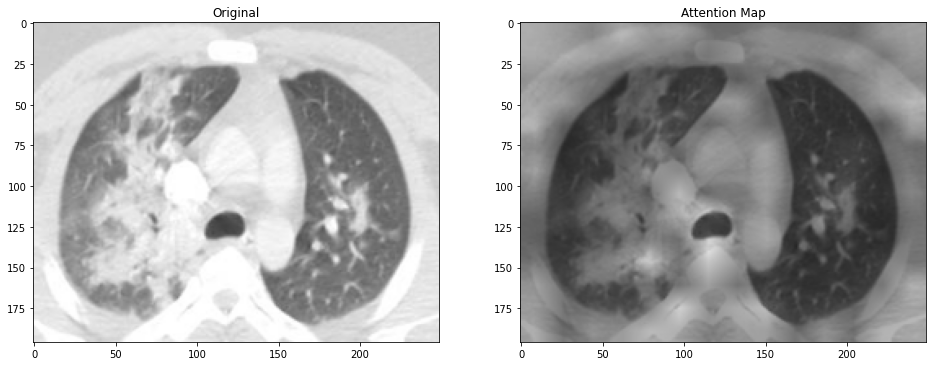

In [33]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 16))

ax1.set_title('Original')
ax2.set_title('Attention Map')
_ = ax1.imshow(im)
_ = ax2.imshow(result)

probs = torch.nn.Softmax(dim=-1)(logits)
top5 = torch.argsort(probs, dim=-1, descending=True)
print("Prediction Label and Attention Map!\n")
# for idx in top5[0, :5]:
#     print(f'{probs[0, idx.item()]:.5f} : {imagenet_labels[idx.item()]}', end='')

### Reference
* [attention_flow](https://github.com/samiraabnar/attention_flow)
* [vit-keras](https://github.com/faustomorales/vit-keras)

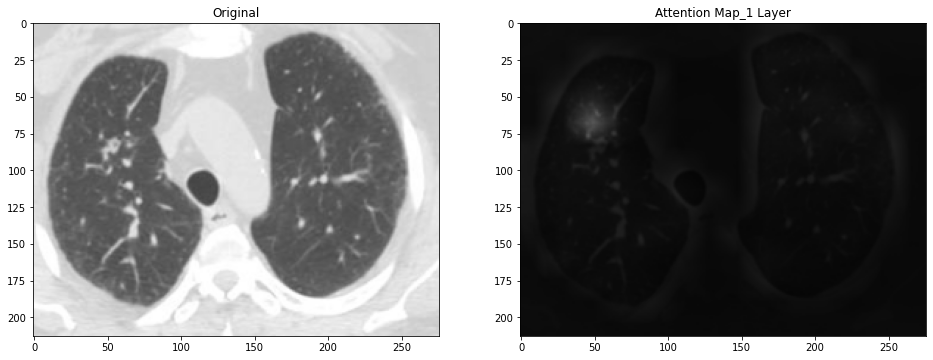

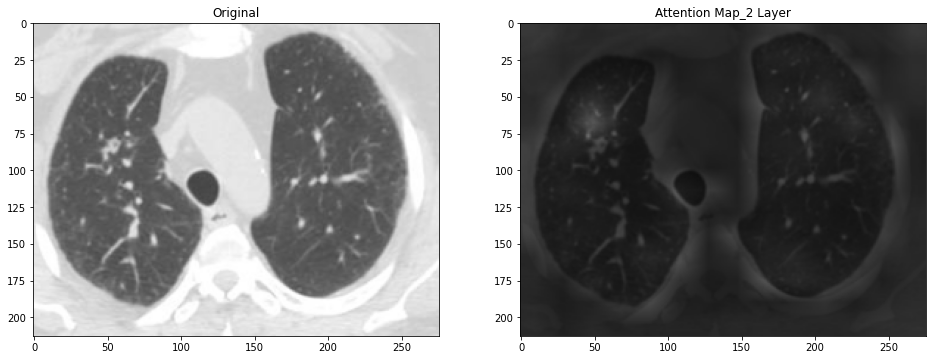

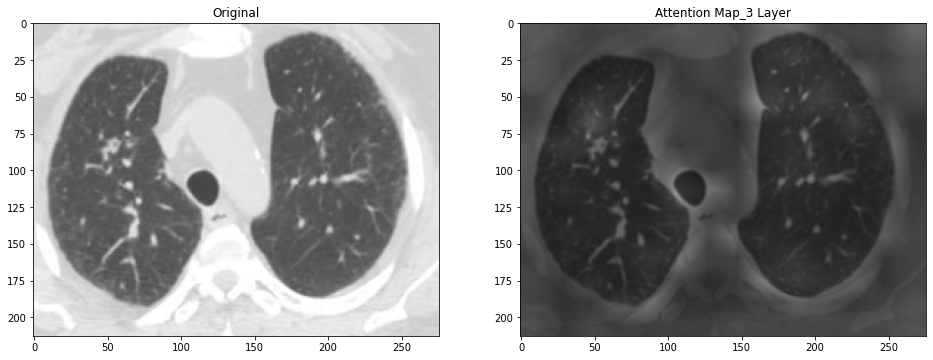

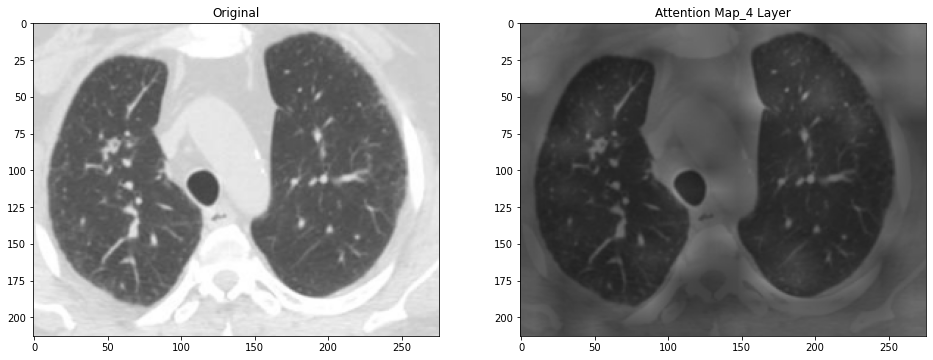

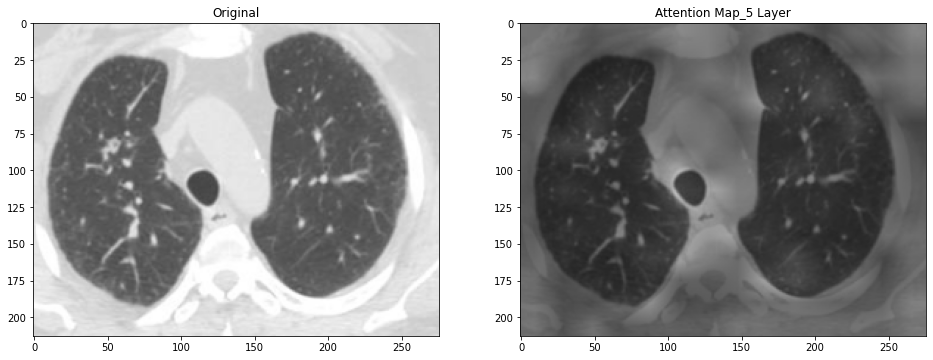

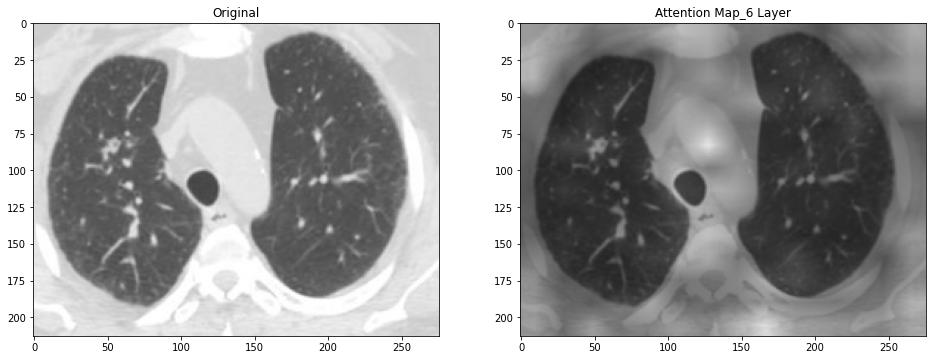

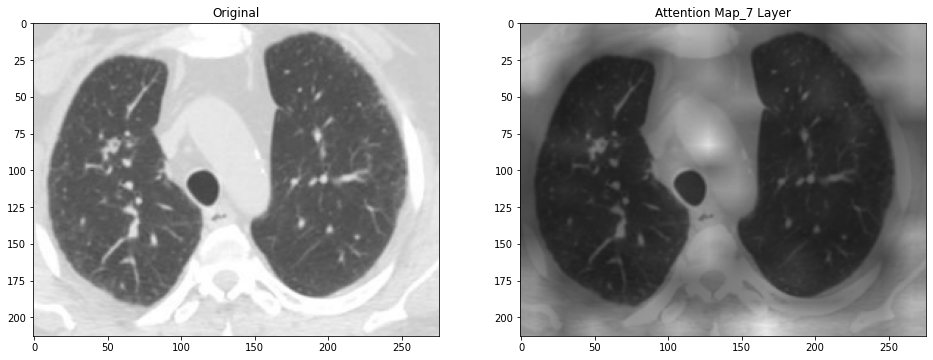

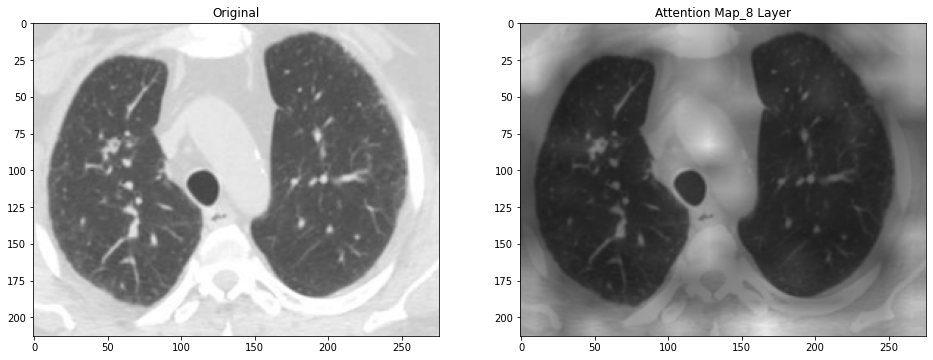

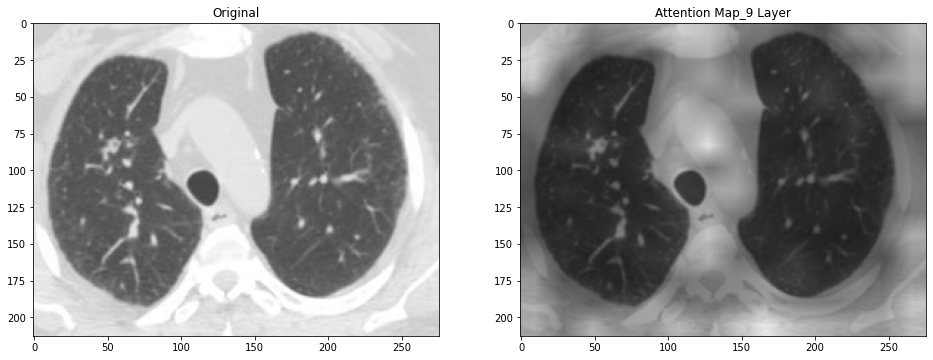

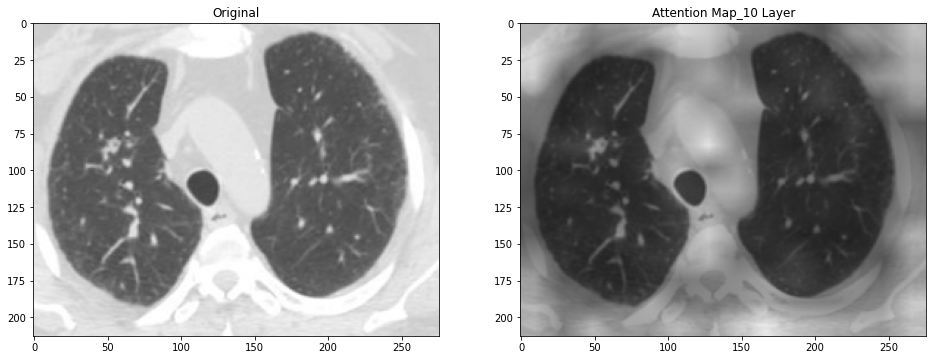

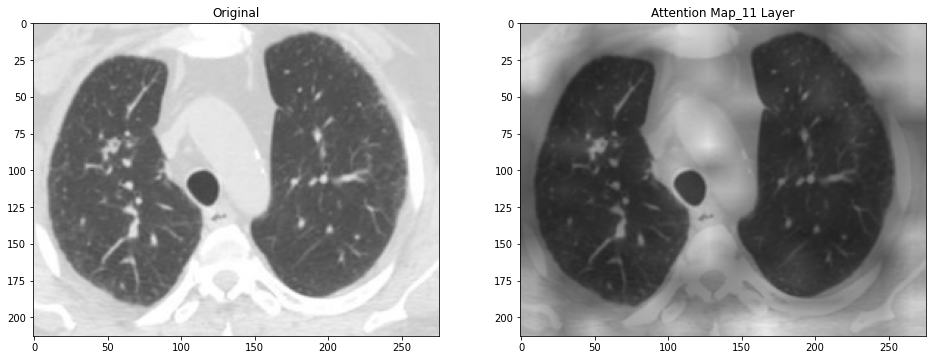

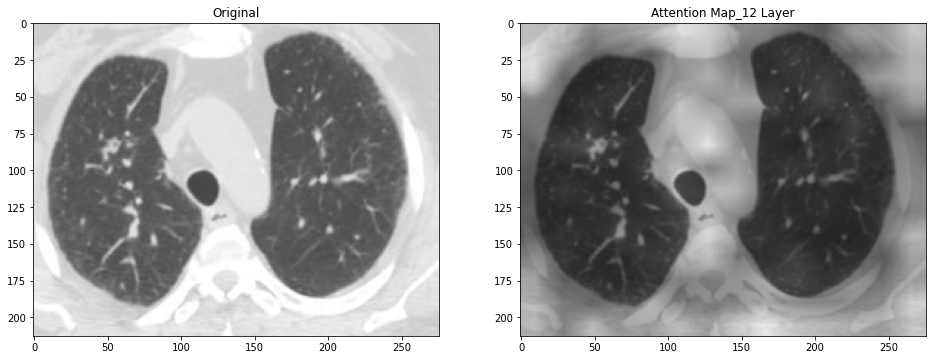

In [30]:
for i, v in enumerate(joint_attentions):
    # Attention from the output token to the input space.
    mask = v[0, 1:].reshape(grid_size, grid_size).detach().numpy()
    mask = cv2.resize(mask / mask.max(), im.size)[..., np.newaxis]
    result = (mask * im).astype("uint8")

    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 16))
    ax1.set_title('Original')
    ax2.set_title('Attention Map_%d Layer' % (i+1))
    _ = ax1.imshow(im)
    _ = ax2.imshow(result)